In [2]:
import stockinator as st
import yfinance as yf
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import requests
import datetime
import time
import os
import sys
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

In [3]:
all_data = pd.read_pickle('stocks/all_1d.pkl')
stocklist = st.unique_list([x[0] for x in all_data.columns.values])
total_stocks = len(stocklist)

In [4]:
exportList = pd.DataFrame(columns=[
    'Stock', 'RSI', 'Price', 
    '90 Avg Volume', '10 Avg Volume', 
    'EMA_1', 'EMA_2', 'EMA_3', 
    '52 Week Low', '52 Week High', 'Pct of 52 High'])

offset = 0
n = -1
for stock in stocklist:
    n += 1
    #print("Index {} of {} Stock [{}] \r".format(n, total_stocks, stock))
    sys.stdout.write("Index {} of {} Stock [{}] \r".format(n, total_stocks-1, stock))
    sys.stdout.flush()

    df = all_data[stock]
    if offset > 0:
        df = df[:-offset]

    df = df.dropna(how='all')
    if df.empty:
        continue

    df = st.calculate_rsi(df)
    df = st.calculate_ema(df, periods=[13, 34, 89])
    df = st.calculate_volume(df)
    df = st.calculate_mfi(df)

    try:
        moving_average_long_21 = df["EMA_3"][-21]
    except Exception:
        moving_average_long_21 = 0

    try:
        currentClose = df["Adj Close"][-1]
        low_of_52week = min(df["Adj Close"][-260:])
        high_of_52week = max(df["Adj Close"][-260:])
        moving_average_short = df["EMA_1"][-1]
        moving_average_medium = df["EMA_2"][-1]
        moving_average_long = df["EMA_3"][-1]
        avg_volume_90 = df['90 Avg Volume'][-1]
        avg_volume_10 = df['10 Avg Volume'][-1]
        rsi = df['RSI'][-1]
    except Exception:
        continue

    try:
        assert(currentClose > 5)
        assert(avg_volume_90 > 250000)
        assert(currentClose > moving_average_short > moving_average_medium > moving_average_long)
        assert(currentClose >= (1.3 * low_of_52week))
        assert(currentClose >= (.75 * high_of_52week))
        #assert(rsi > 40)
        #assert(rsi < 60)
        assert(avg_volume_10 > avg_volume_90)
    except AssertionError:
        continue
    except IndexError as e:
        continue
    except Exception as e:
        print(e)

    try:
        exportList = exportList.append(
            {
                'Stock': stock, 
                'RSI': rsi, 
                'Price': currentClose,
                '90 Avg Volume': avg_volume_90,
                '10 Avg Volume': avg_volume_10,
                'EMA_1': moving_average_short, 
                'EMA_2': moving_average_medium, 
                'EMA_3': moving_average_long, 
                '52 Week Low': low_of_52week, 
                '52 Week High': high_of_52week,
                'Pct of 52 High': (currentClose / high_of_52week) * 100
            }, ignore_index=True)
    except Exception as e:
        print(e)

In [6]:
print(exportList.sort_values('Pct of 52 High', ascending=True))
exportList.sort_values('Pct of 52 High', ascending=False).to_csv('stocks.csv', index=False)

   Stock        RSI       Price  90 Avg Volume  10 Avg Volume       EMA_1       EMA_2       EMA_3  52 Week Low  52 Week High  Pct of 52 High
49  TWOU  73.843822   31.330000     1654951.40      2603492.6   27.766484   24.900726   23.494410    12.510000     41.570000       75.366851
51  KURA  70.631017   15.920000      495119.80       857288.2   14.357420   12.533315   12.126387     6.450000     20.870001       76.281741
43  PSTI  57.595254    9.620000     1536243.09      1984397.8    9.328963    8.005546    6.081999     2.890000     12.430000       77.393400
77  ANET  60.810113  228.880005      905552.93       940886.4  218.412342  211.132641  208.863958   157.039993    287.359985       79.649226
34     Z  64.864813   52.070000     4020337.16      4370894.4   47.440901   43.408283   42.674054    25.010000     65.000000       80.107692
62  SCPL  73.562278   12.880000      271334.02       528716.2   11.686915   10.655274   10.311881     6.340000     16.000000       80.500001
52  HEAR  59.

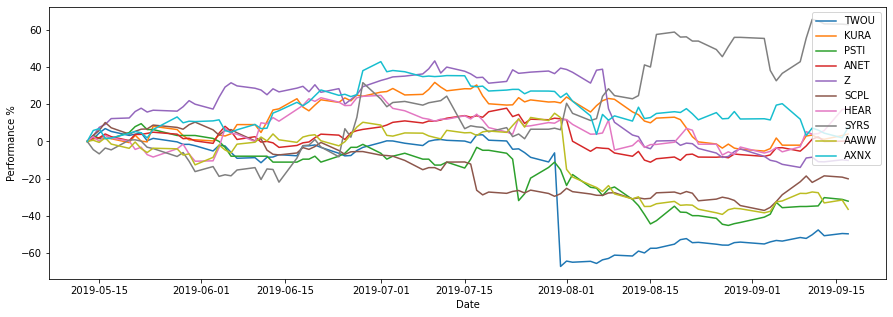

In [7]:
top10 = exportList.sort_values('Pct of 52 High', ascending=True)[0:10]
plt.figure(figsize=(15,5))
plt.xlabel("Date")
plt.ylabel("Performance %")
for s in top10.Stock.values:
    perf = all_data[s][-offset:-offset+89]
    change = (perf.Close - perf.iloc[0]['Close']) / perf.iloc[0].Close
    plt.plot(perf.index, change*100, label=s)
plt.legend()
plt.show()

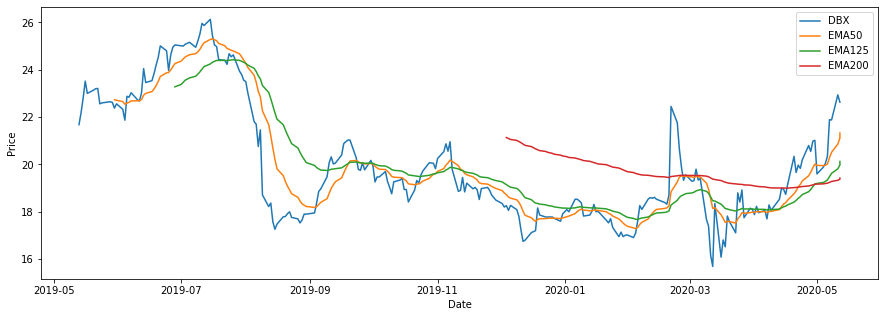

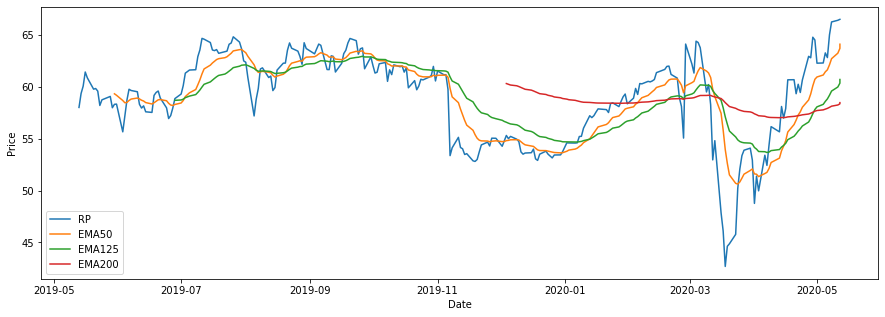

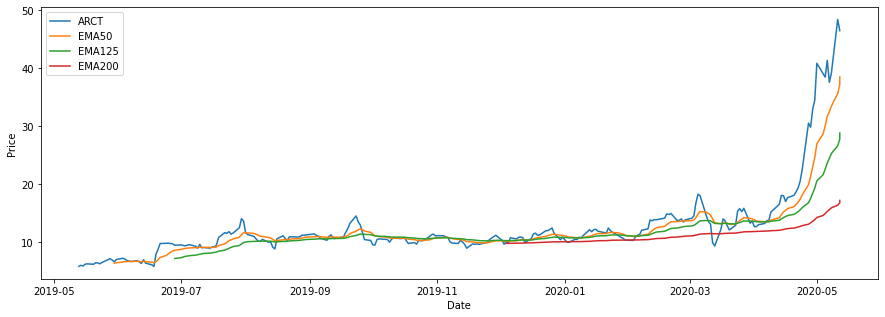

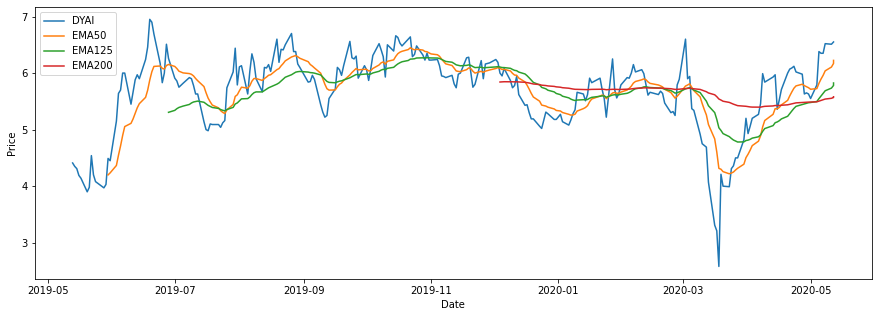

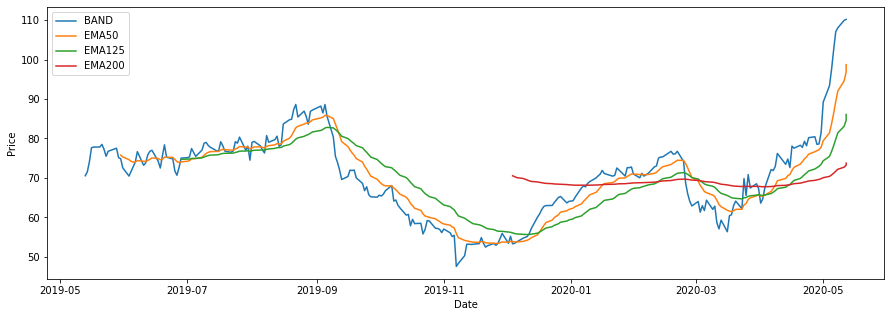

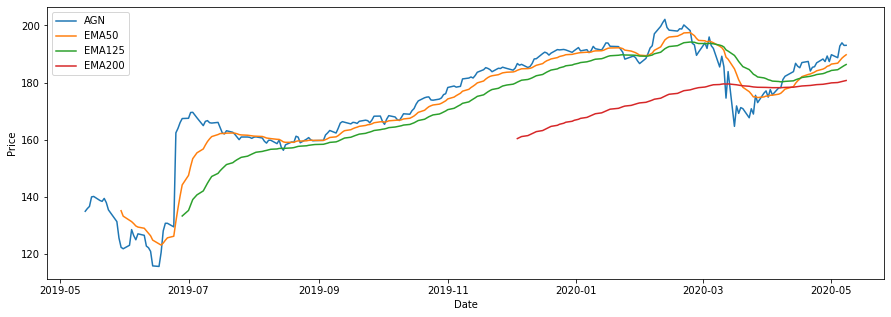

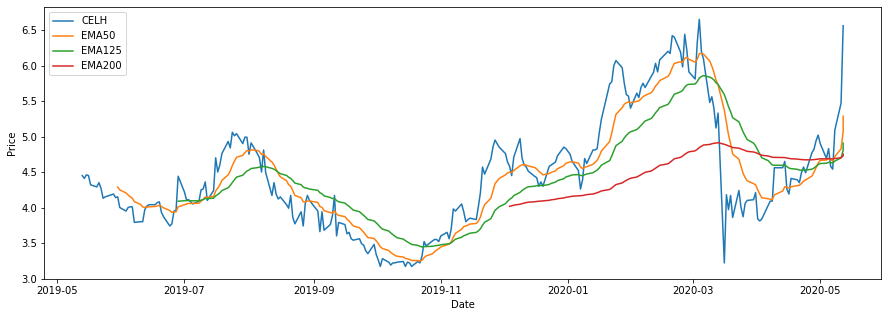

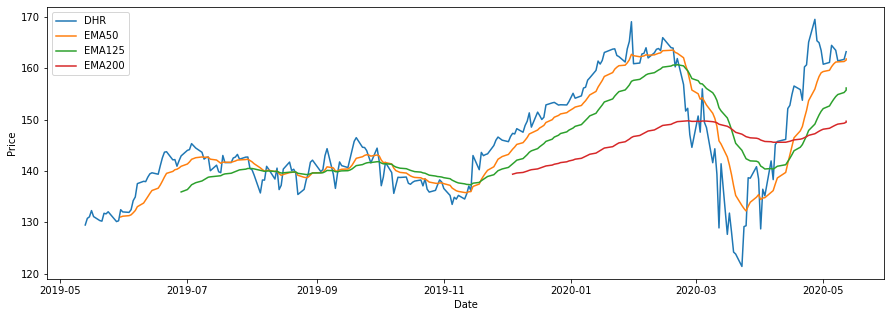

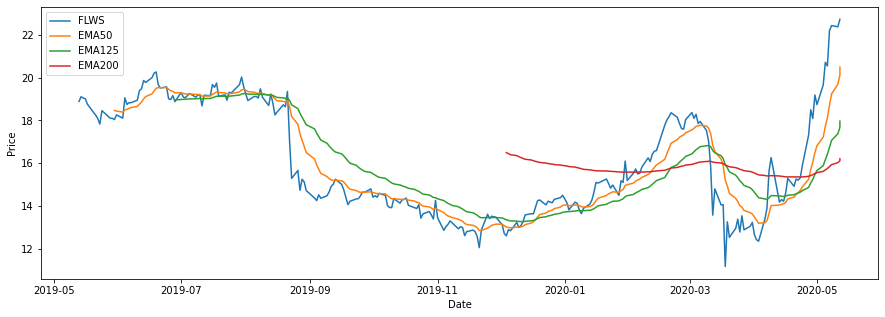

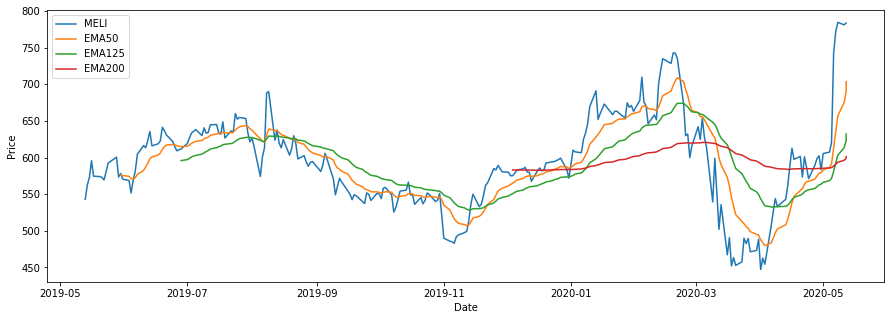

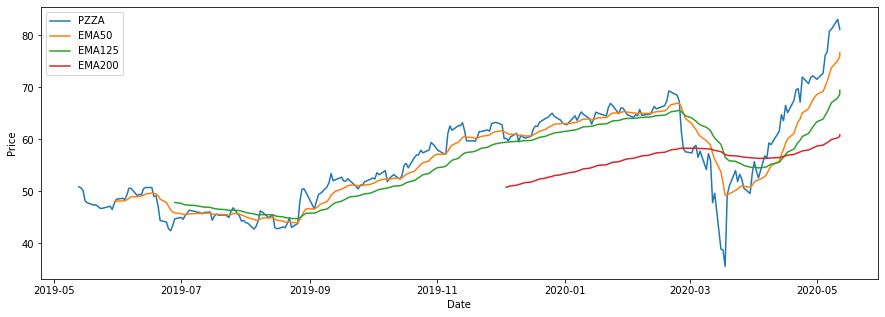

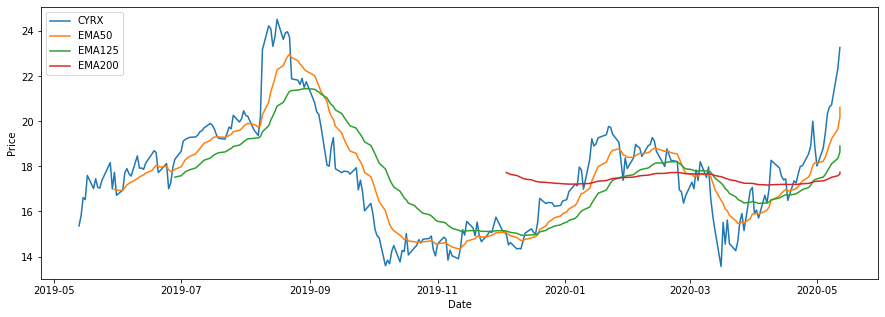

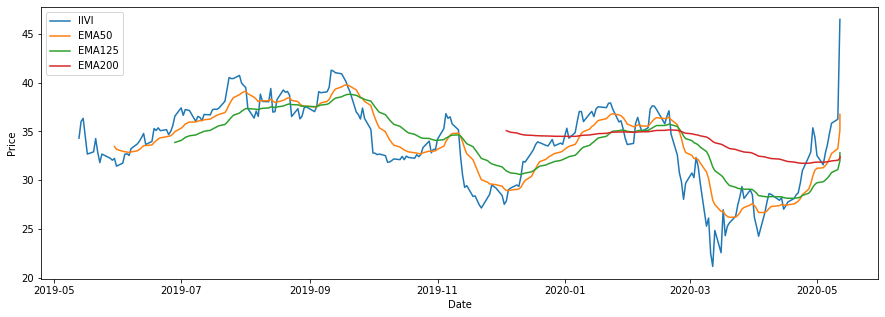

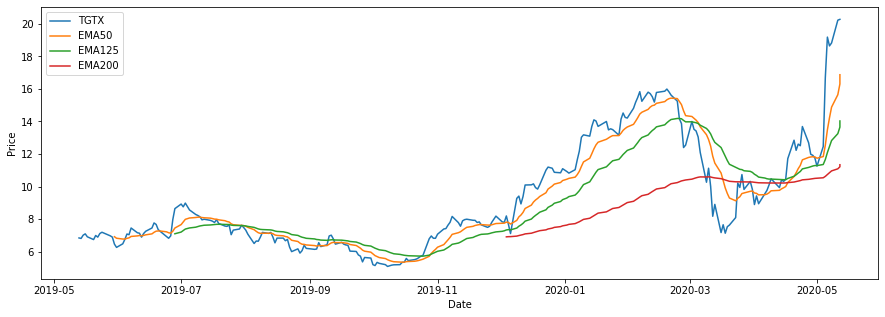

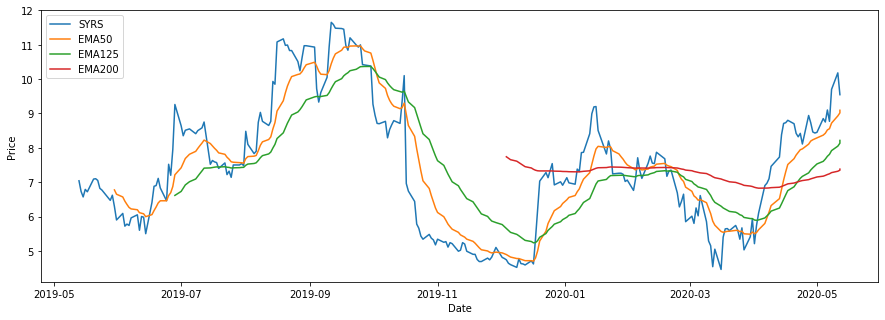

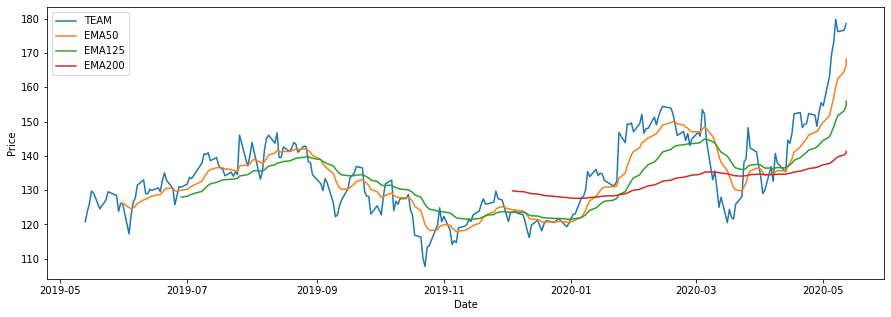

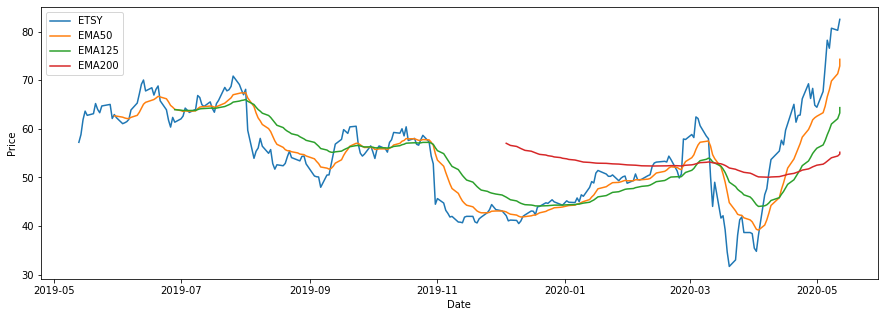

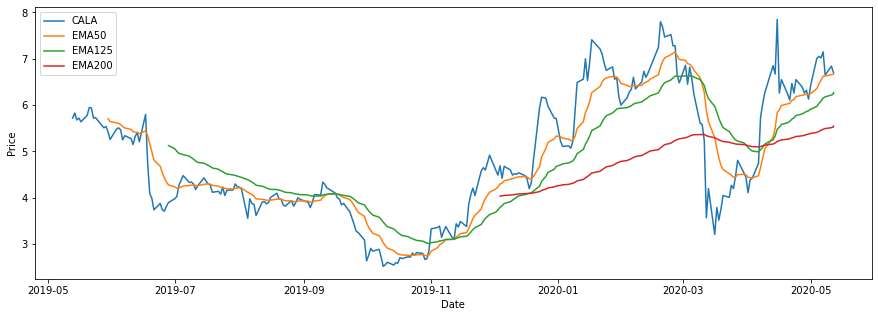

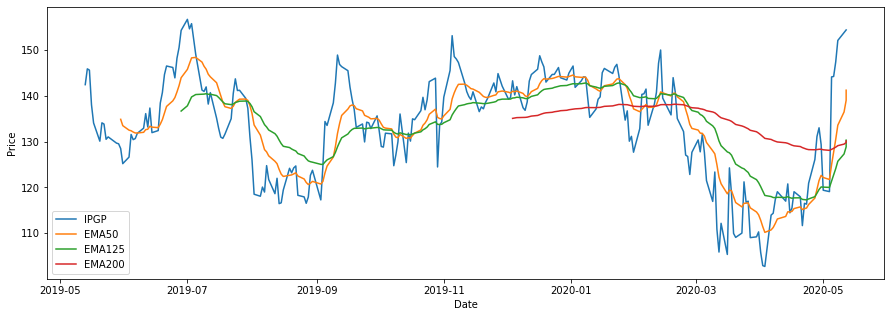

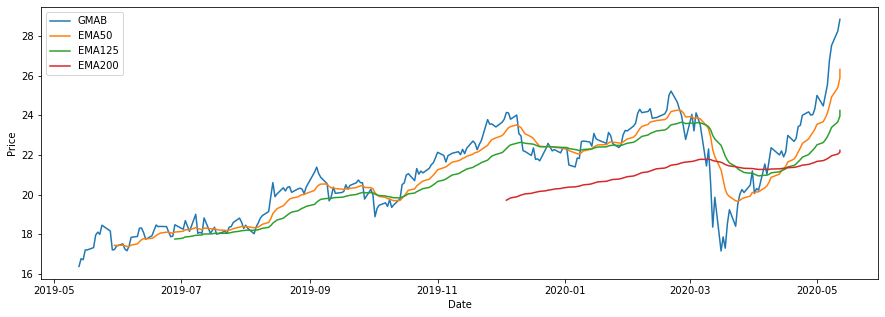

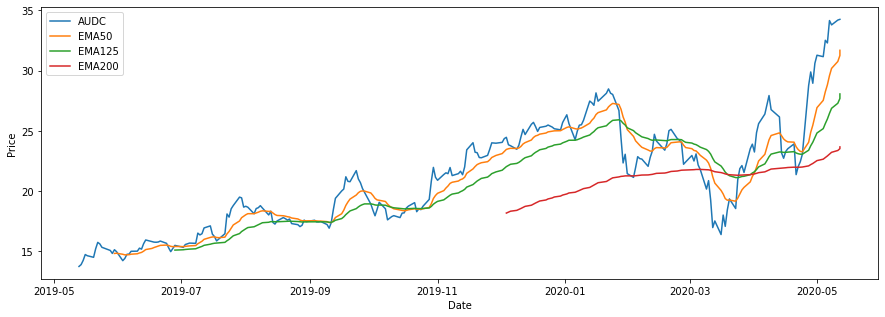

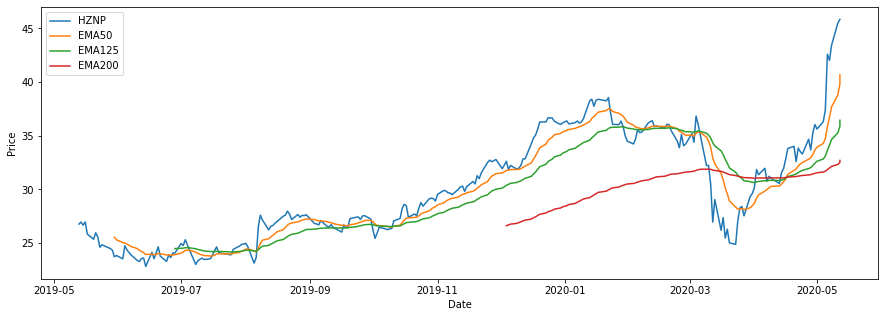

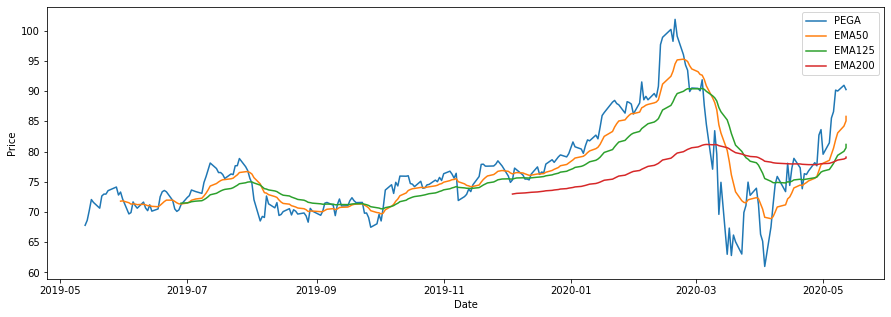

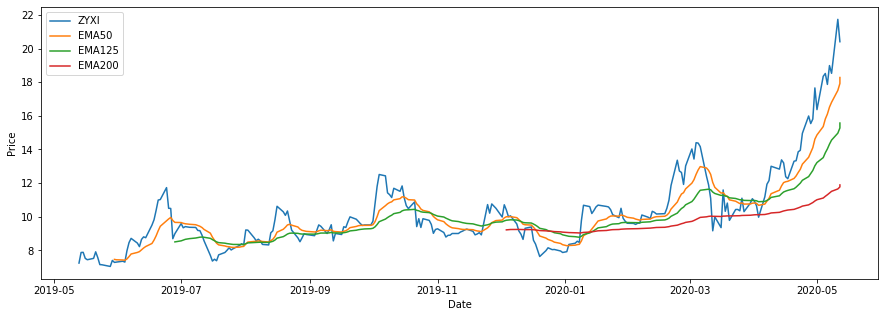

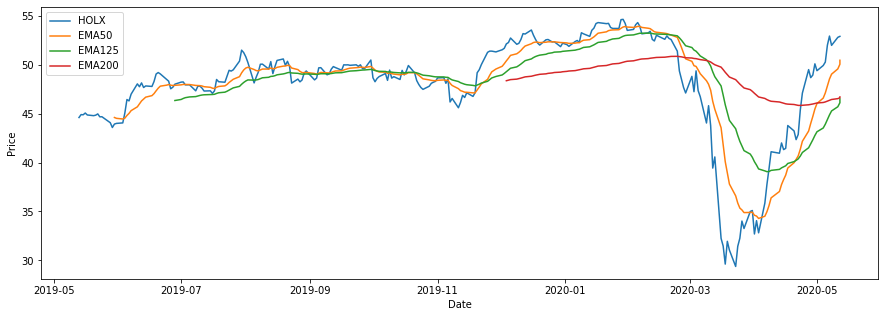

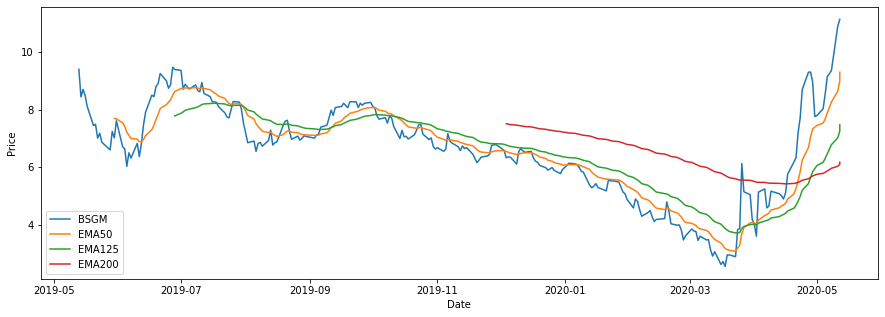

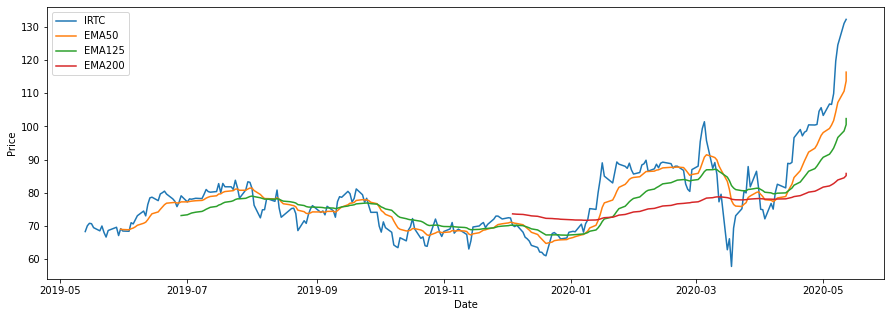

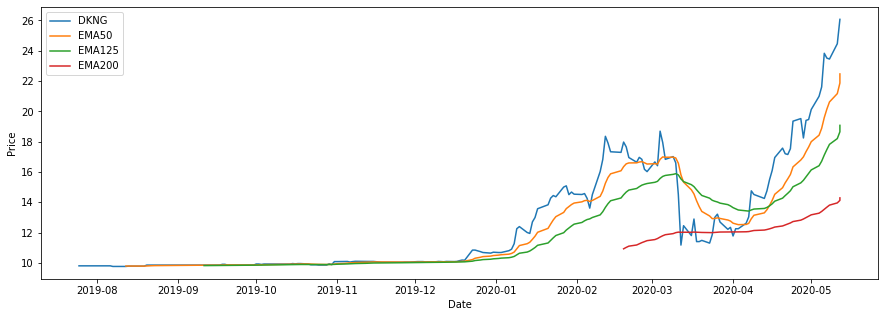

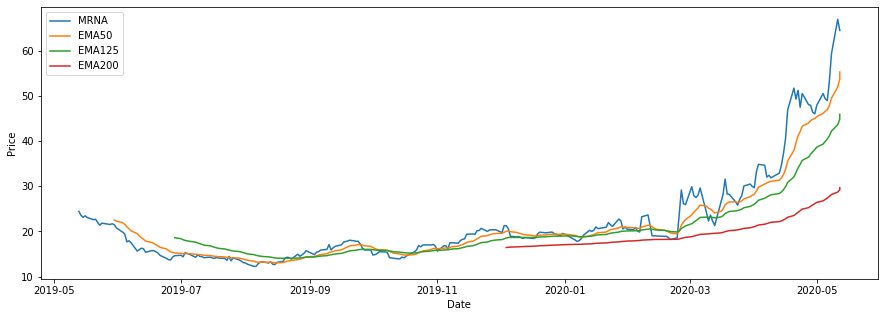

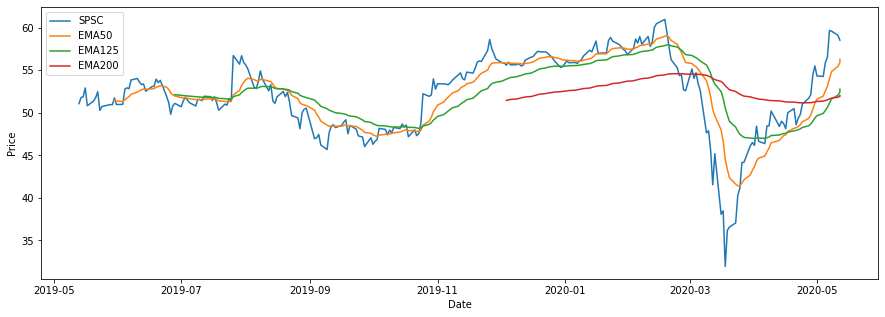

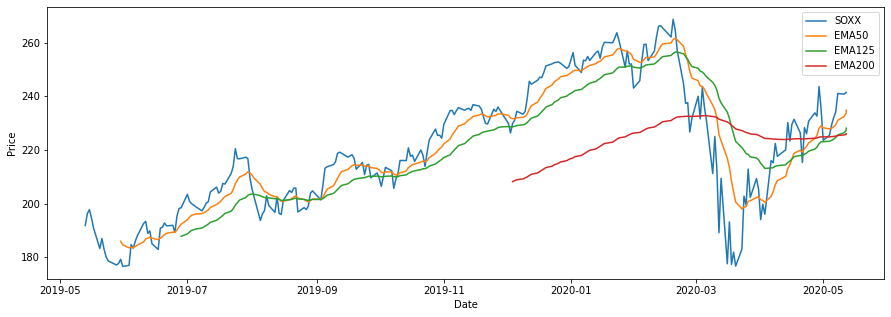

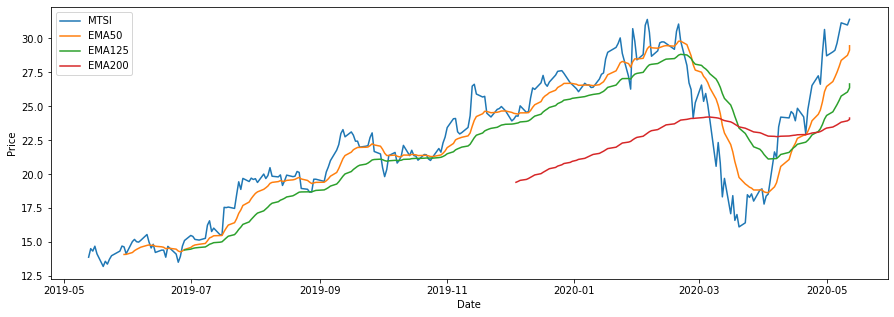

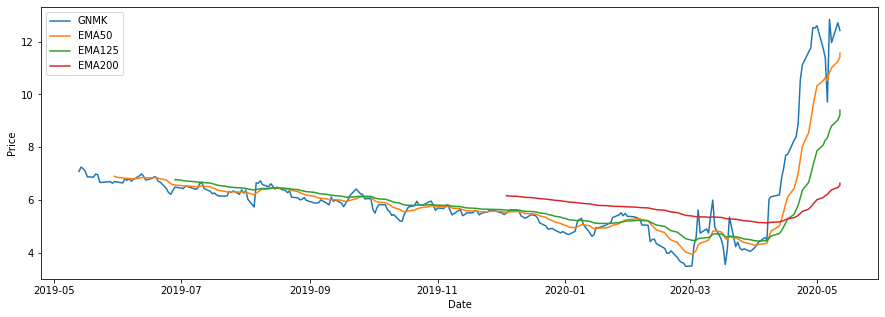

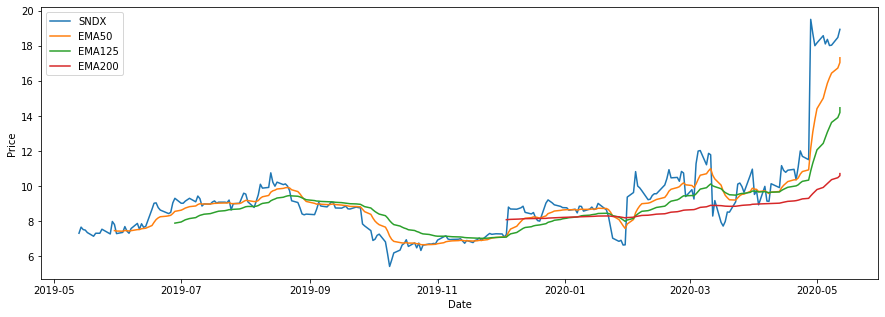

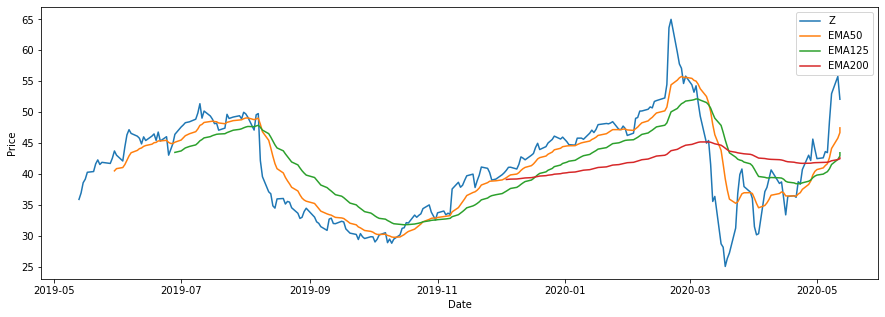

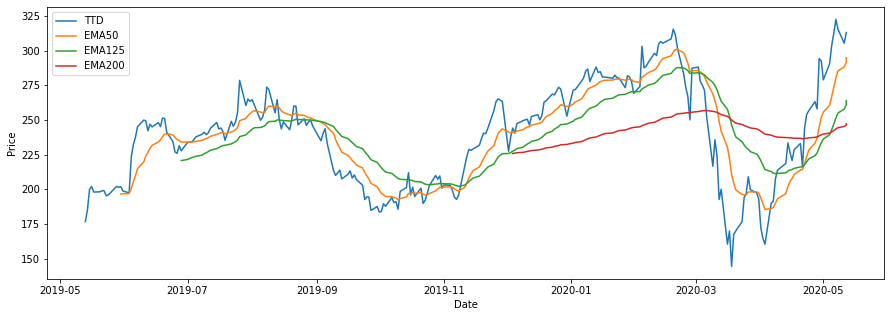

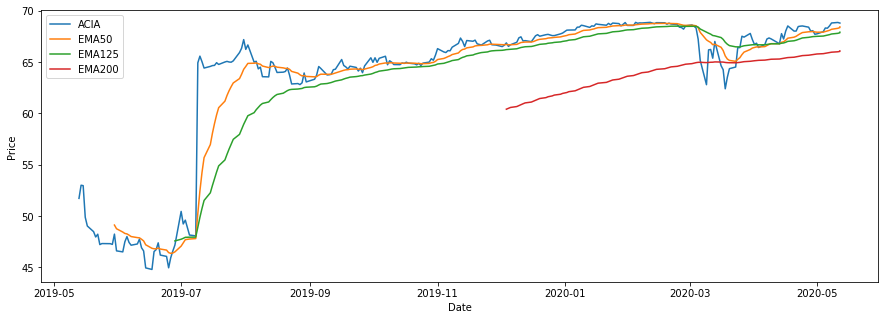

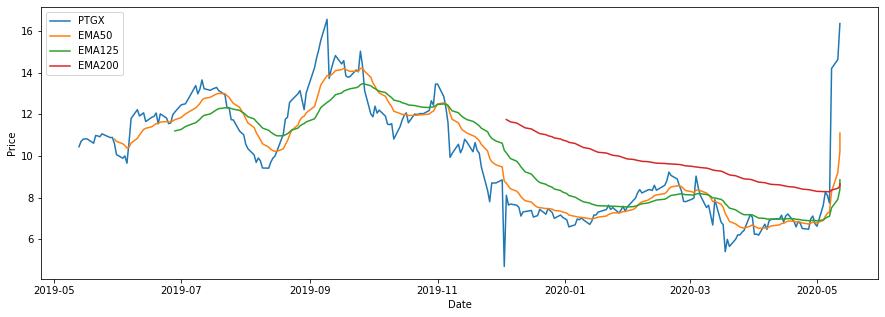

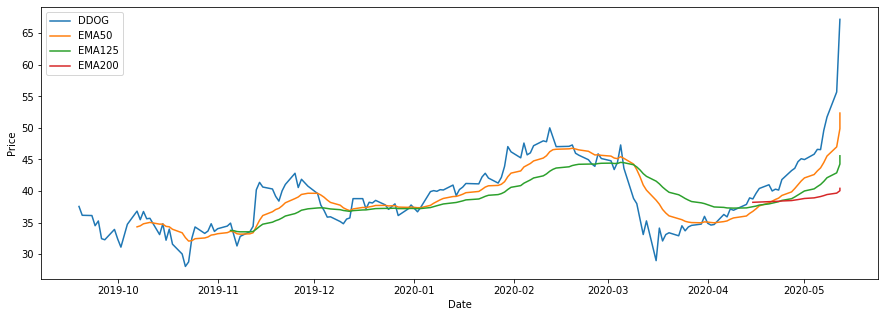

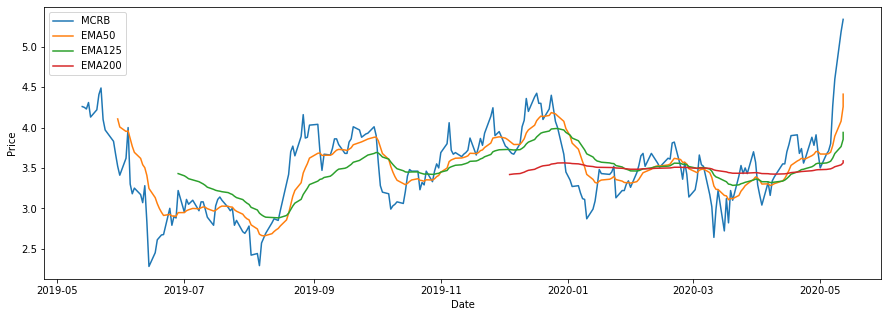

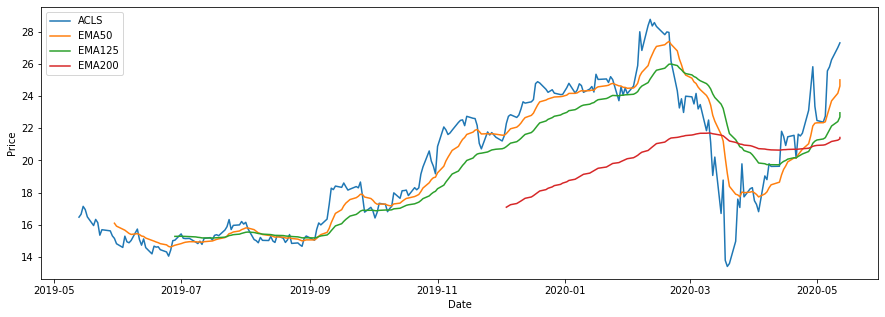

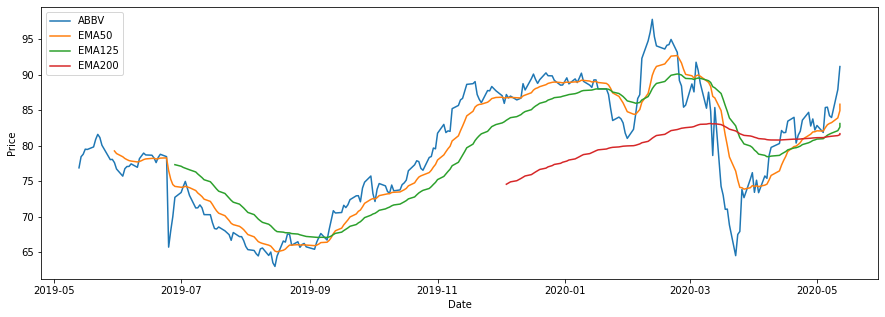

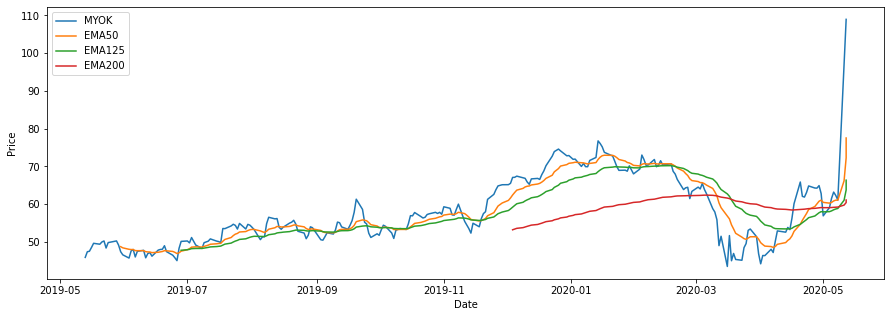

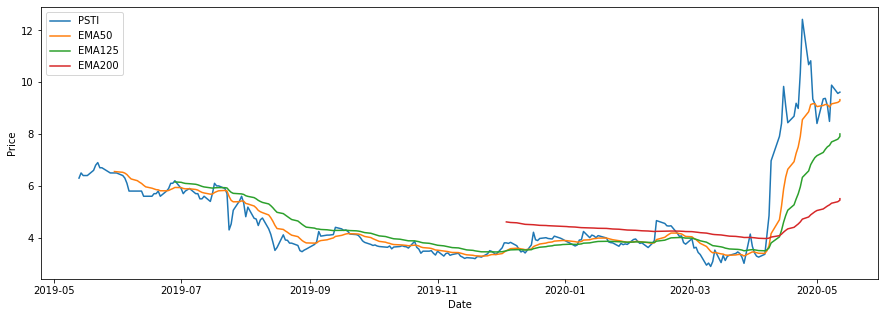

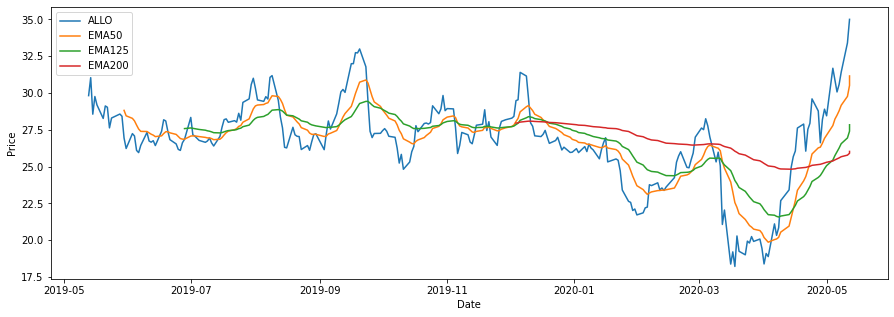

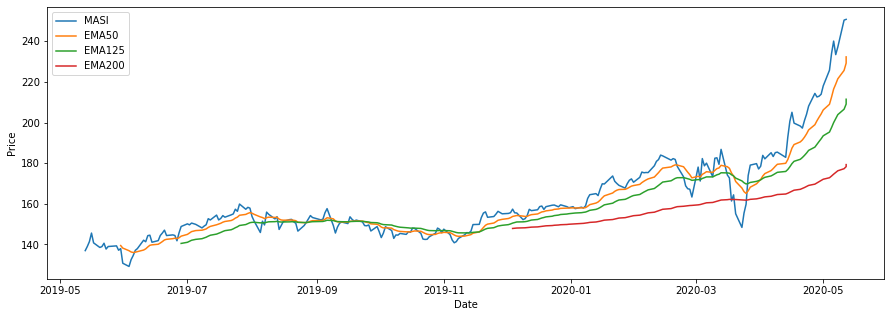

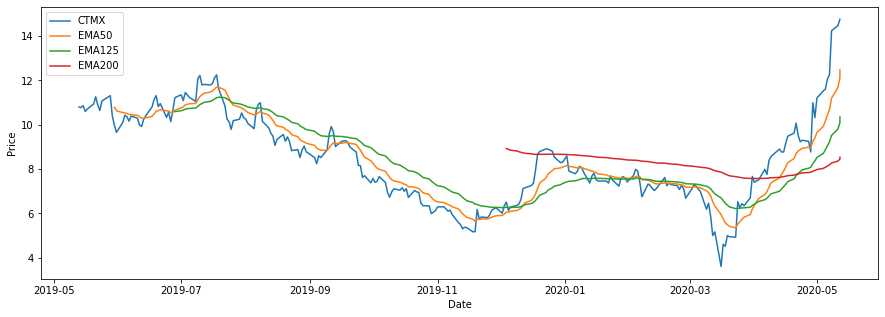

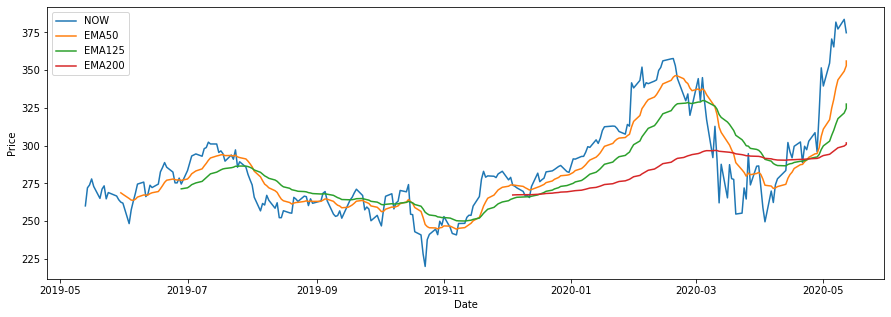

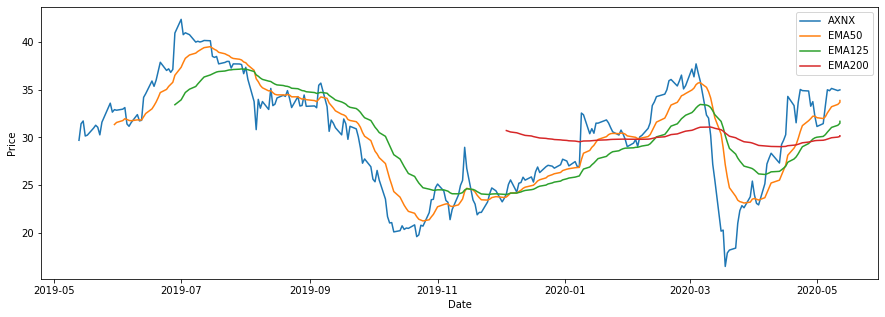

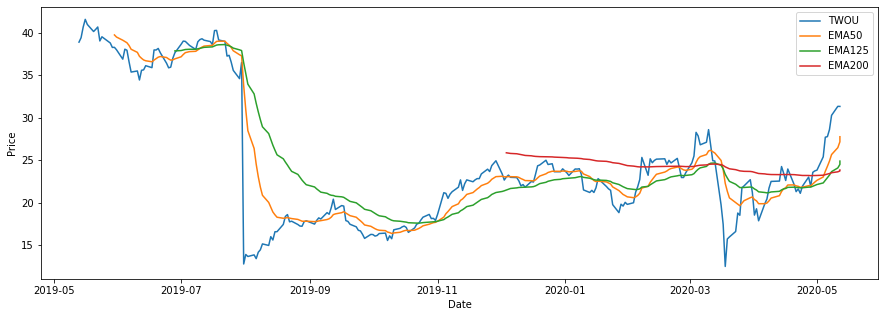

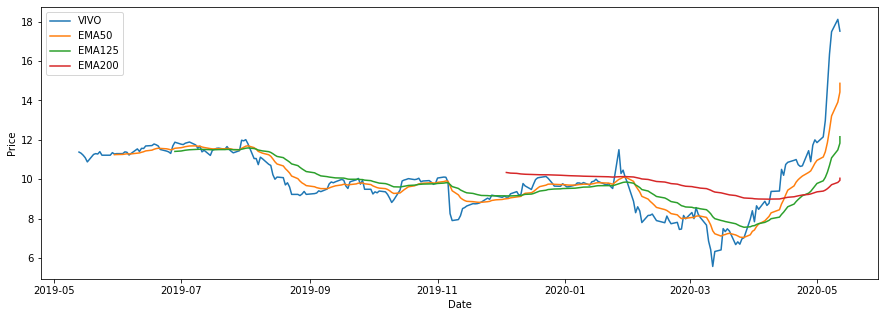

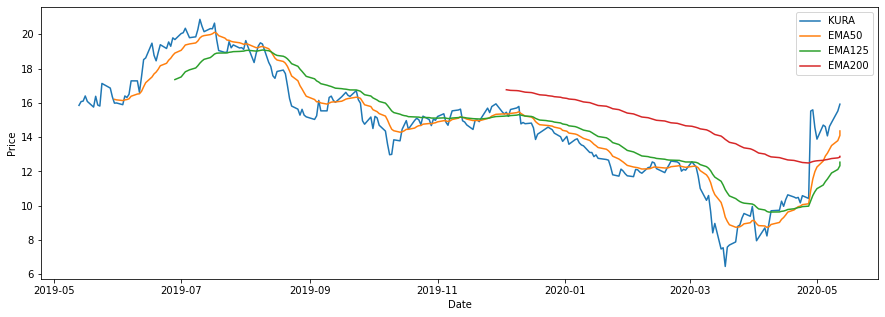

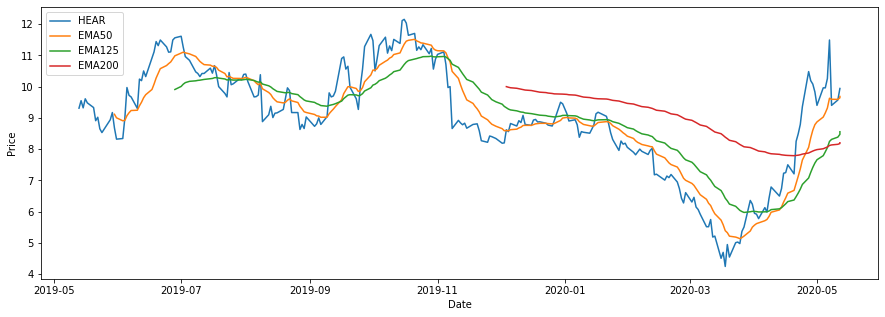

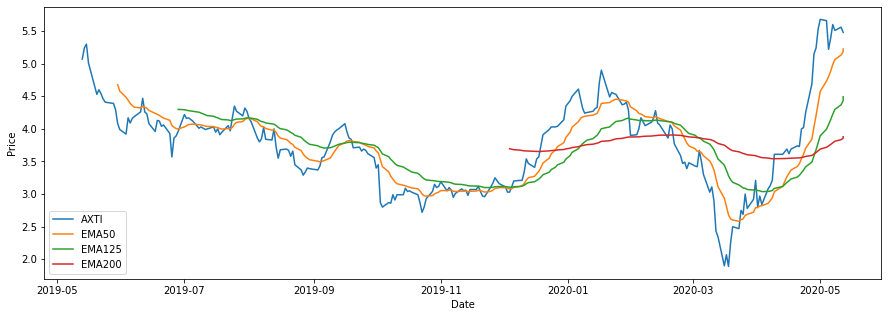

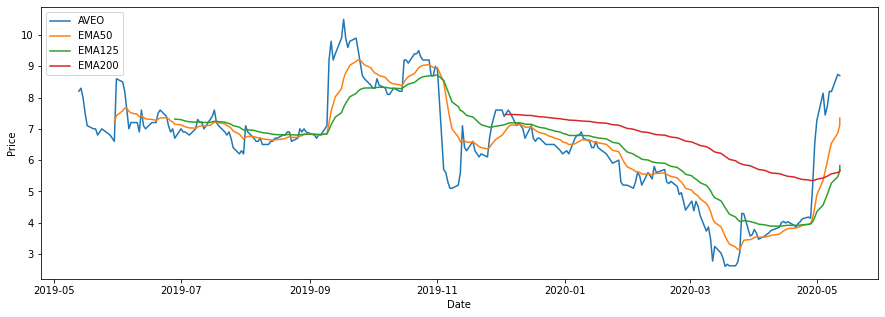

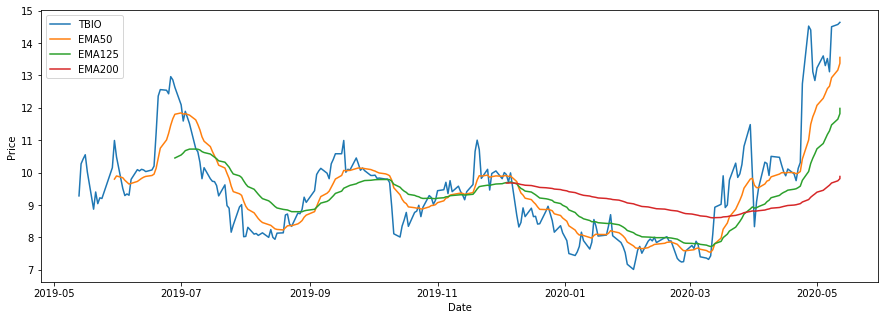

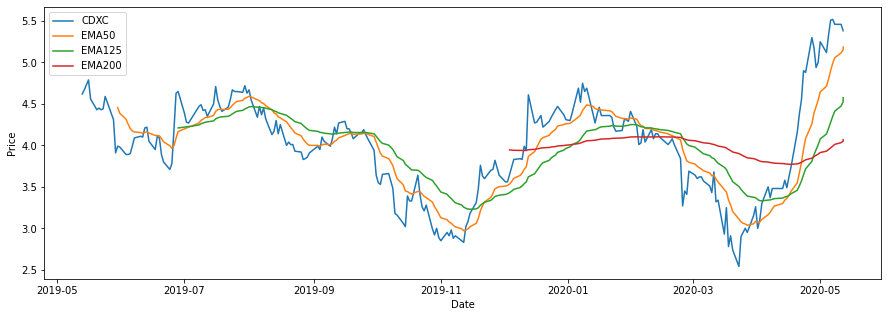

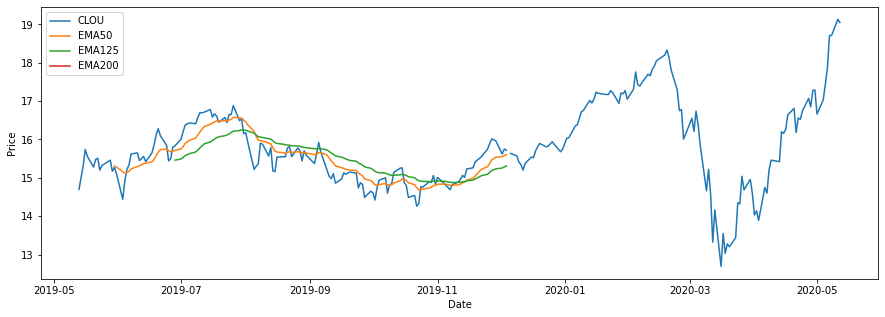

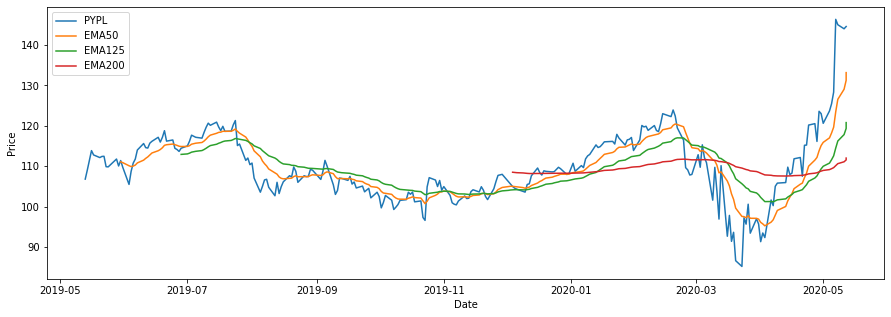

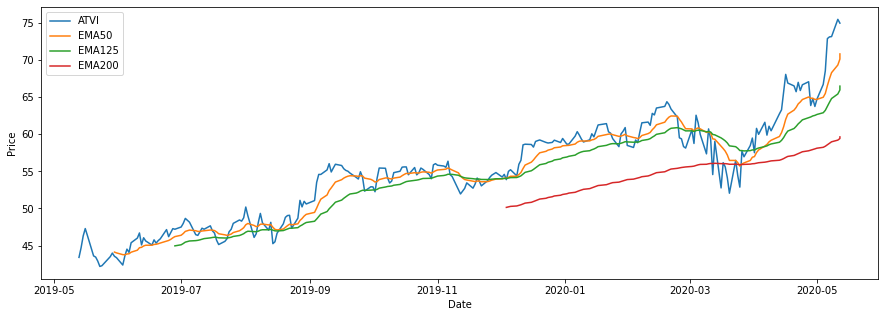

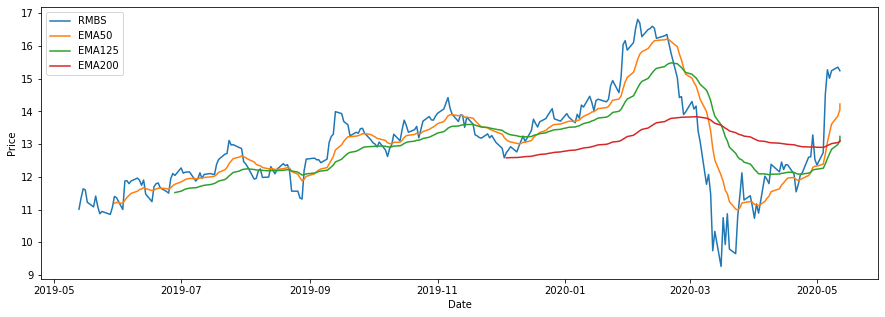

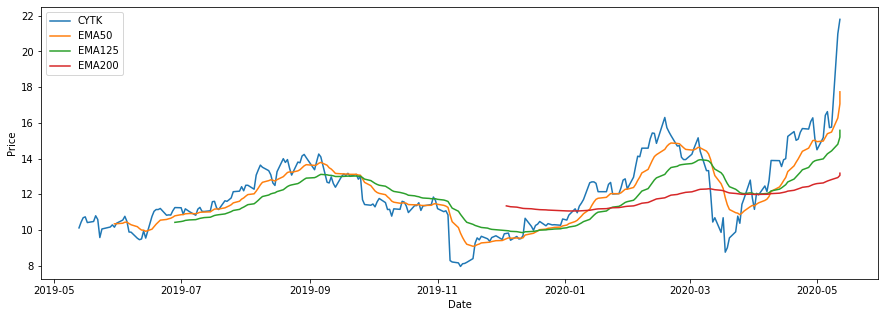

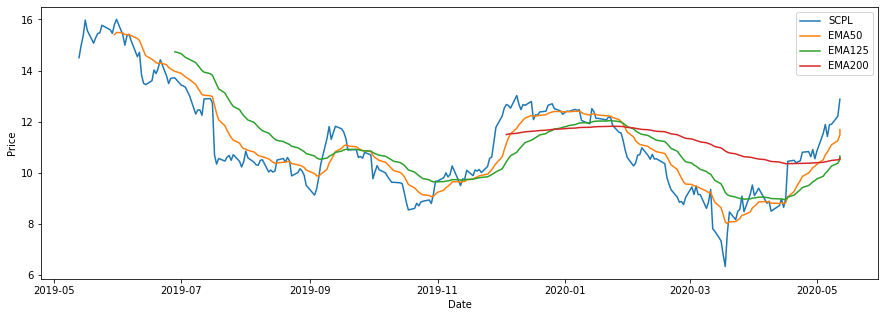

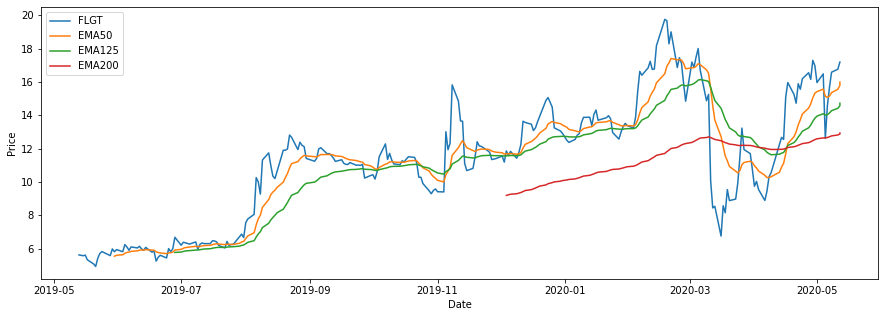

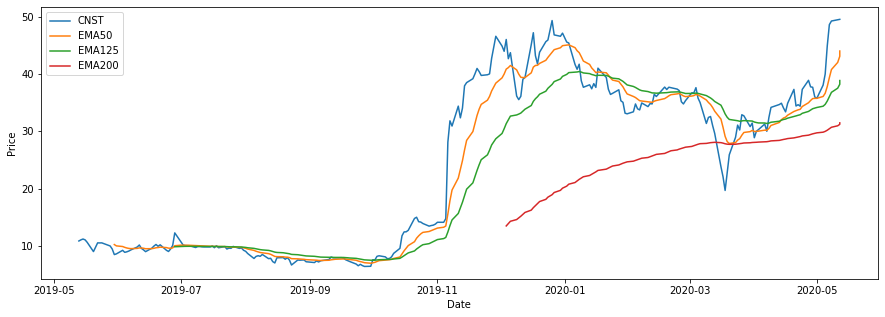

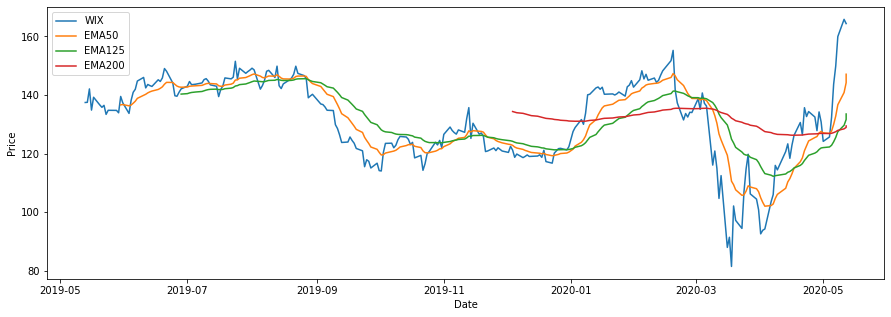

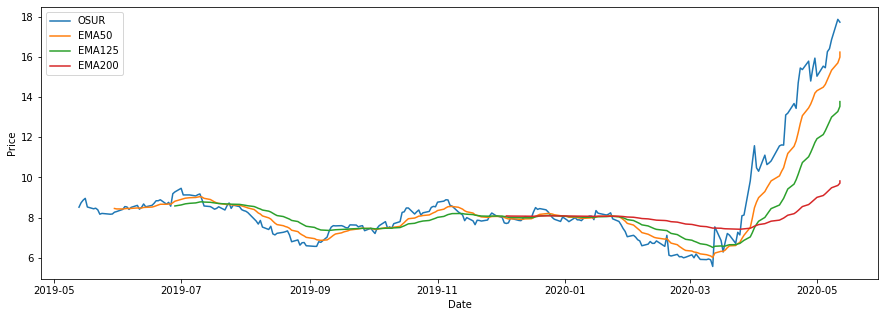

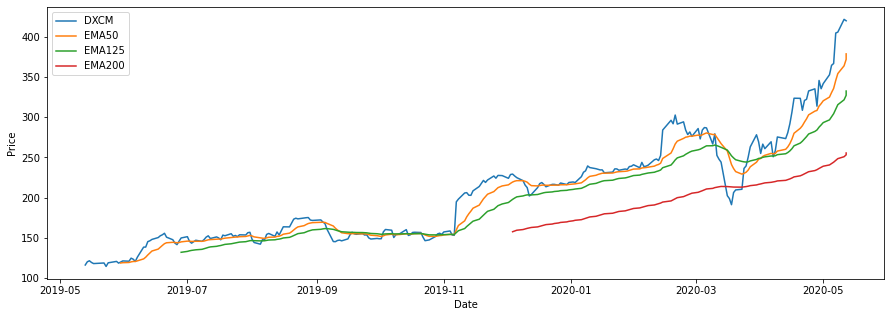

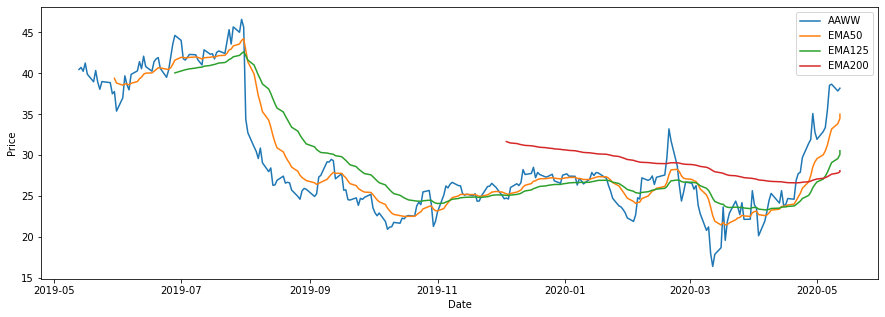

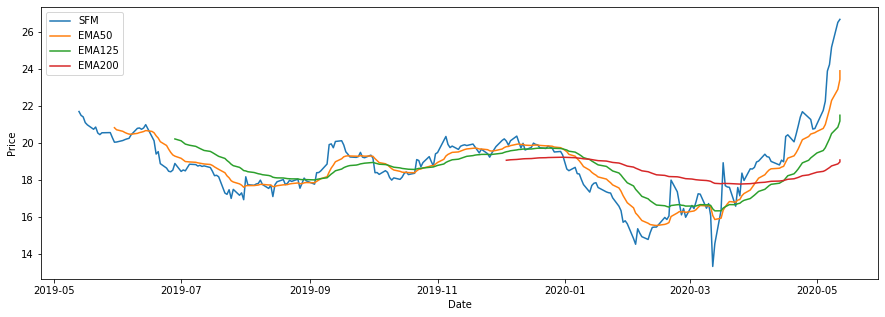

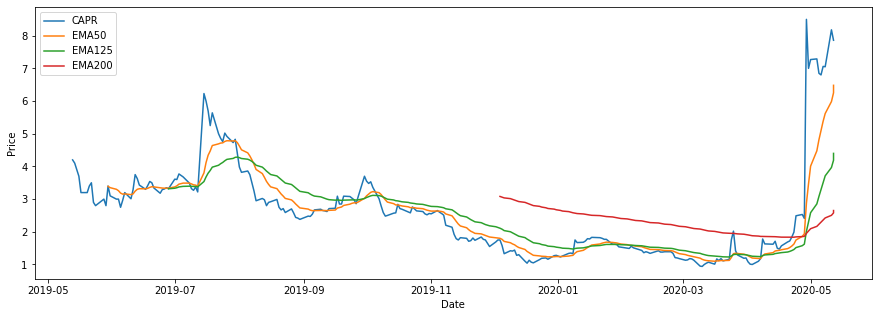

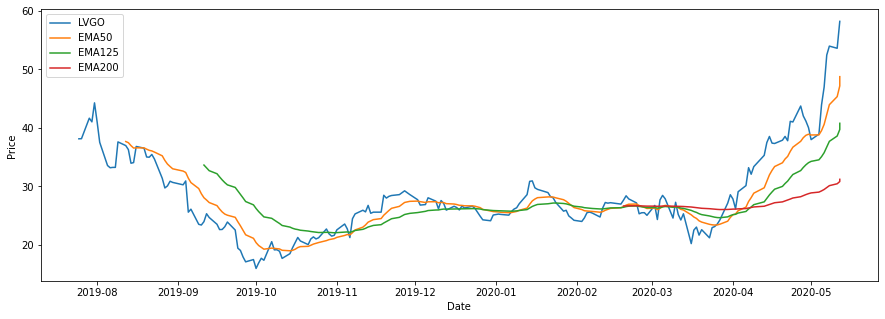

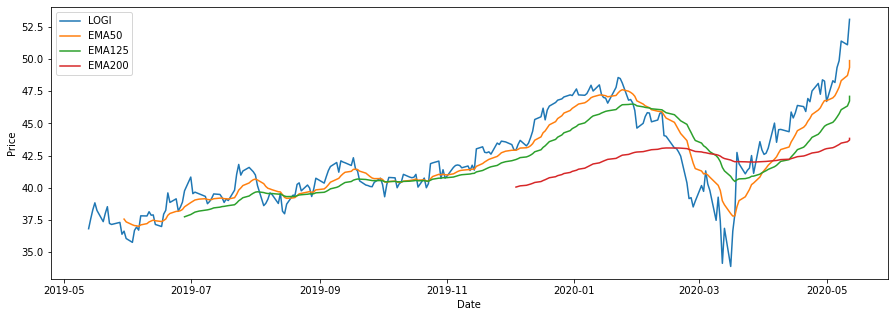

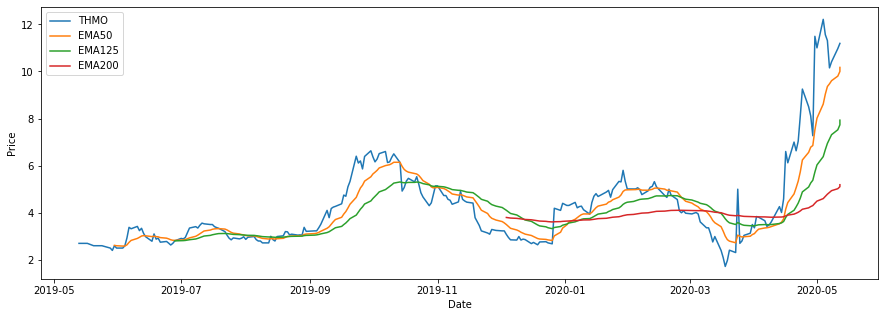

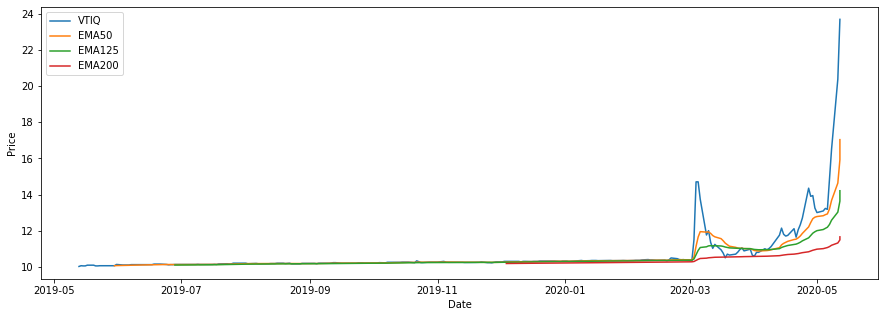

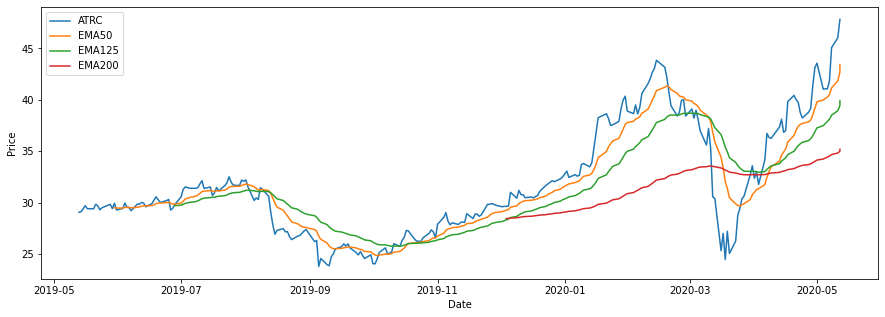

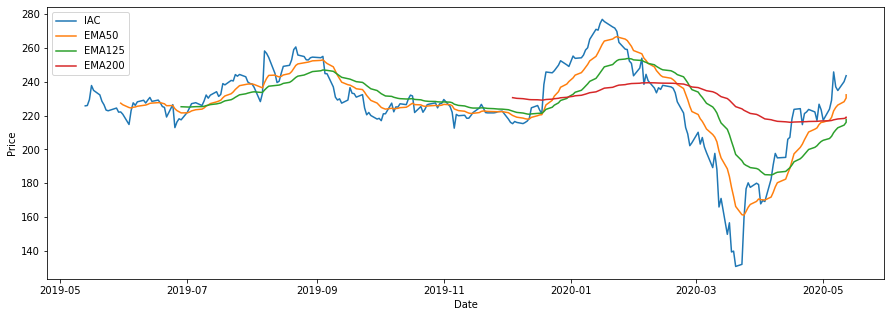

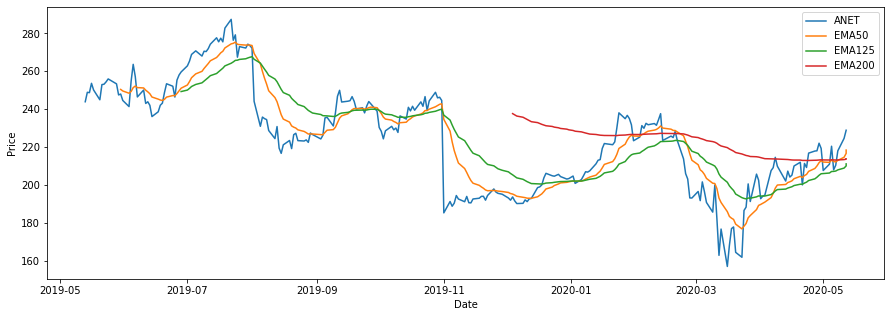

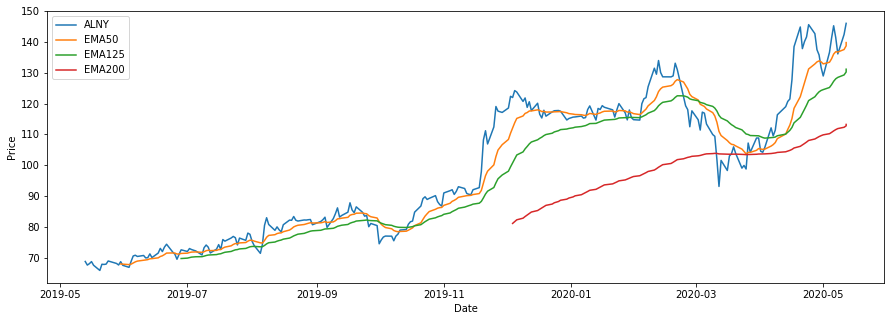

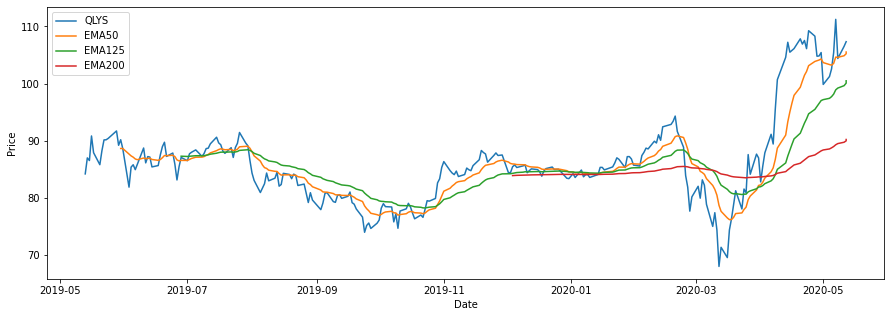

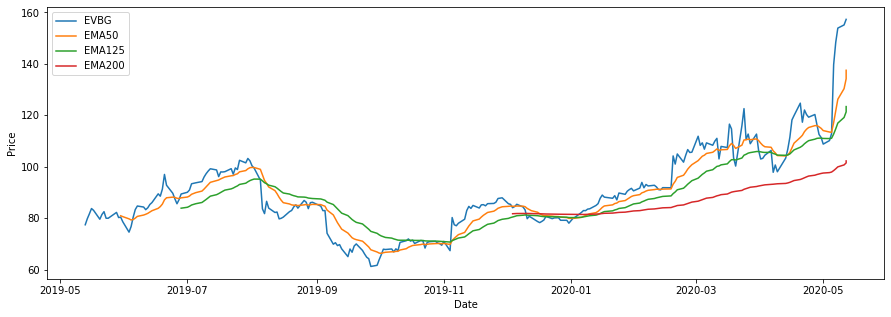

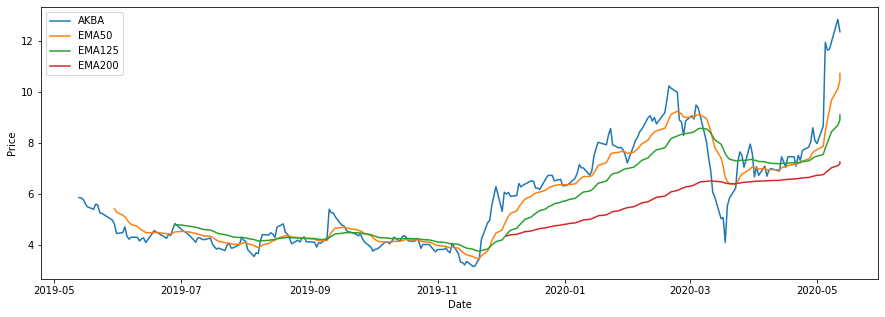

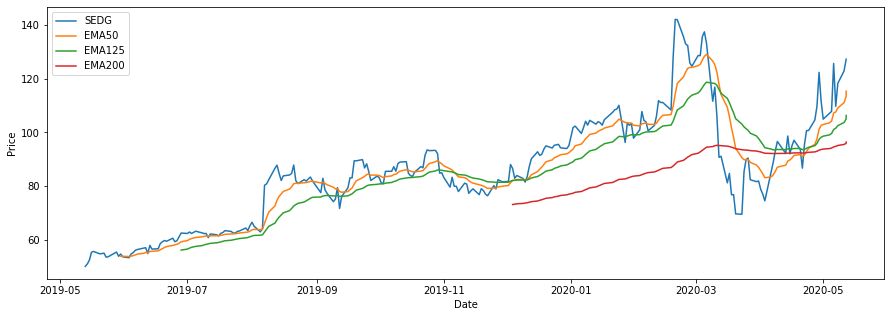

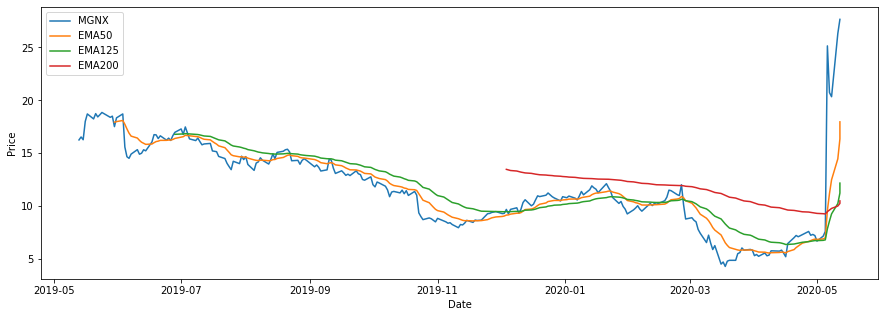

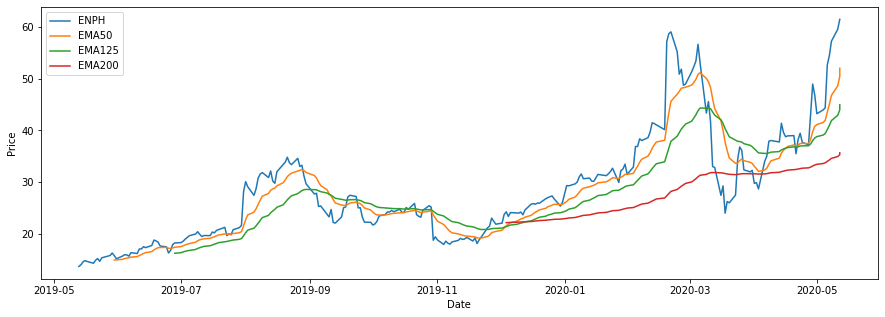

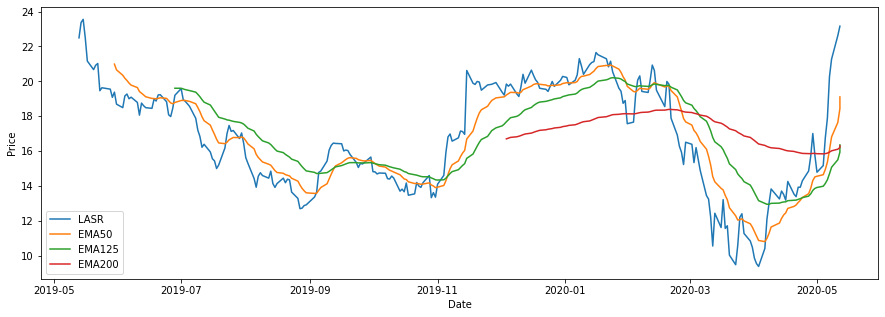

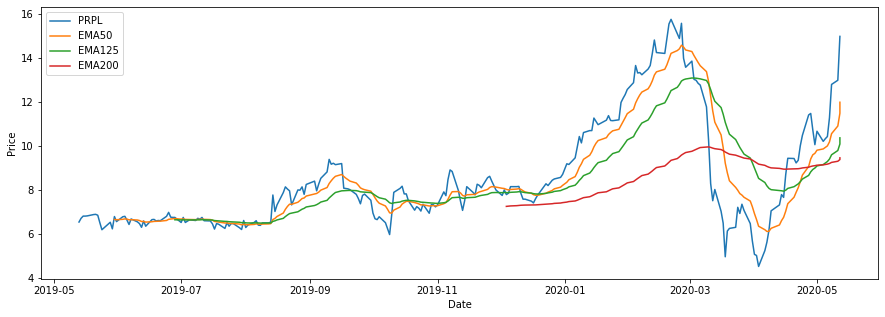

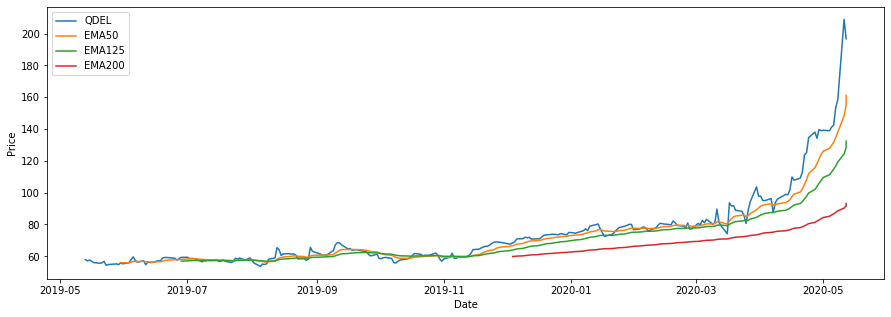

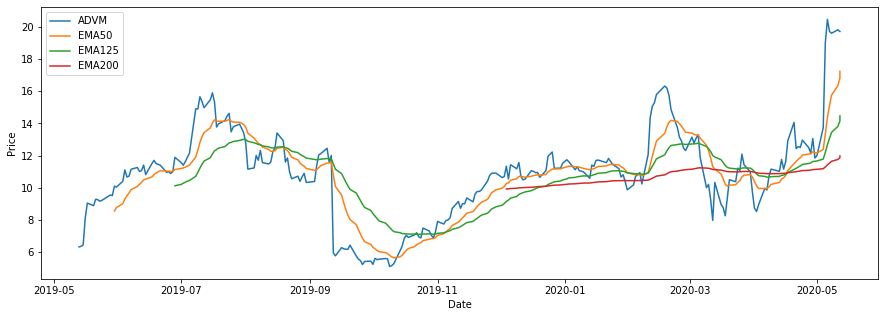

In [10]:
for s in exportList.Stock.values:
    perf = all_data[s]
    plt.figure(figsize=(15,5))
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.plot(perf.index, perf.Close, label=s)
    plt.plot(perf.index, ta.EMA(perf.Close, timeperiod=13), label='EMA50')
    plt.plot(perf.index, ta.EMA(perf.Close, timeperiod=34), label='EMA125')
    plt.plot(perf.index, ta.EMA(perf.Close, timeperiod=144), label='EMA200')    
    plt.legend()
    plt.show()